In [1]:
#Libraries
#1) Importing Data
import os
from scipy.io import loadmat #Importing Matlab data

#2) Dataset Manipulation
import pandas as pd

#3) Mathematical/Statistical computation
import numpy as np
import numpy.ma as ma #Correlation while ignoring the missing data
import statistics as stat

#4) Plotting
import matplotlib
import matplotlib.pyplot as plt
# -> cf) magic function for IPython and Jupyter Notebook to show the graph well
# -> cf) In original Python, % means remainder from the division so below will not work
# -> cf) %matplotlib inline 
import matplotlib.dates as mdates #Date Library
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

#5) Regressions 
import statsmodels.formula.api as sm # Regression with Formula
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from linearmodels.iv import results
from linearmodels.compat.statsmodels import Summary
from linearmodels.compat.statsmodels import summary
from linearmodels.iv import compare
#from linearmodels.datasets import mroz #Why Do We Need?
#from linearmodels import PanelOLS #Maybe we do not need
import statsmodels.formula.api as smf #For Newey-West Covariance Matrix

#6) Regression Results to Tex Output
from statsmodels.iolib.summary2 import summary_col # Regression Output Table
#import tabulate
#from tabulate import tabulate
#print(tabulate([['Alice', 24], ['Bob', 19]], headers=['Name', 'Age'], tablefmt='orgtbl'))

#7) Math
import math

#8) Random Number Generator
import random

#9) f-SOLVER
import scipy
from scipy import stats
from scipy.stats import lognorm
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy import interpolate

#10) numba
from numba import jit, jitclass, njit, prange, int64, float64
import numpy
import math
import time
from scipy.stats import norm
from collections import OrderedDict
import sys

In [2]:
#0. Read parameters for the shocks form parameter file.
os.chdir('C:\\Users\\Owner\\Dropbox\\1. Research\\1. Risks in Household Portfolio Choice through Jeonse System\\Coding')
parameterset=pd.read_csv('parameter.csv')  
FullshockFinal=pd.read_csv('FullShockFinal1.csv')  
lambdaPS=pd.read_csv('survivalprob.csv')
LIncomeGrowthProcess=pd.read_csv('LIncomeGrowthProcess.csv')

In [3]:
#2. Paramters spaces

#2.1. Household Problem Parameters
omega=parameterset['Parameter'][0] #housing versus non-durable consumption
rho=parameterset['Parameter'][1] #inverse of the elasticity of intertemporal substitution 
gamma=parameterset['Parameter'][2] #CRRA risk aversion
beta=parameterset['Parameter'][3] #discount factor
xi=parameterset['Parameter'][4] #probability of moving - Vestman 2019 different for each age
alpha_f=parameterset['Parameter'][5] #bequest strength (annuity factor)
beta_b=parameterset['Parameter'][6] #bequest strength (discount factor)
T_b=parameterset['Parameter'][7] #bequest strength (time period)
lambda_r=parameterset['Parameter'][8] #ratio of retirement income to the last working age income
R_f=parameterset['Parameter'][9] #risk free rate
mu_r=parameterset['Parameter'][10] #risk premium 
mu_h=parameterset['Parameter'][11] #expected growth of house price
tau_r=parameterset['Parameter'][12] #ratio of yearly rent to house price
Jbar=parameterset['Parameter'][13] #ratio of Jeonse deposit to house price -> Refer to the R.file
delta_J=parameterset['Parameter'][14] #downpayment ratio for Jeonse
phi_J=parameterset['Parameter'][15] #Jeonse contract cost 
chi=parameterset['Parameter'][16] #maintenance fee
delta=parameterset['Parameter'][17] #downpayment ratio for home purchase
phi_b=parameterset['Parameter'][18] #House purchase cost
phi=parameterset['Parameter'][19] #selling cost
Hbar=parameterset['Parameter'][20] #minimum house value (lower than it, rent or jeonse)
delta_v=parameterset['Parameter'][21] #standard deviation of idiosyncratic labor income shock
delta_ep=parameterset['Parameter'][22] #standard deviation of idiosyncratic stock market return
delta_n=parameterset['Parameter'][23] #standard deviation of housing return
corrHS=parameterset['Parameter'][24] # correlation between housing return and stock return correlation
eta_en=parameterset['Parameter'][25] # coefficient in front of stock return shock so that it goes into housing return equation for correlation.
corrYS=parameterset['Parameter'][26] # correlation between labor income and stock return
corrHY=parameterset['Parameter'][27] # correlation between housing return and labor income
eta_nn=parameterset['Parameter'][28] # coefficient for shock correlated to housing return and exist in labor income shock part
eta_eo=parameterset['Parameter'][29] # coefficient for shock correlated to stock return and exist in labor income shock part
LT=parameterset['Parameter'][30] #Longevity 20 - 80
b_b=parameterset['Parameter'][31] #bequest constant multiplier

#2.2. Life Cycle Parameters
LIncomeGrowthProcess=np.array(LIncomeGrowthProcess['0']) #deterministic labor income growth profile
lambdaPS=np.array(lambdaPS['0']) #survival probability conditional on age
#lambdaPS=np.array(lambdaPS)

#2.3. Shock Processes (i.i.d) in my case
FullshockFinal=pd.DataFrame(FullshockFinal) #Possible shock realization and probability 
LaborIncomeShock=np.array(FullshockFinal.YgridV+FullshockFinal.SgridV_Y+FullshockFinal.HgridV_Y, dtype=float)
HousePriceShock=np.array(FullshockFinal.HgridV+FullshockFinal.SgridV_H, dtype=float)
StockReturnShock=np.array(FullshockFinal.SgridV, dtype=float)
Probability=np.array(FullshockFinal.Prob, dtype=float)

In [4]:
LT=35

In [72]:
#3. Setting up the grid for (y,h)

# Grid for y (wage / cash-in-hand) - it should be inverse...
ny            = int(30);
invymin          = 0.5;
invymax          = 12.0;
# Function to construct the grid for laborincome/cash-in-hand (y)
ygrid = numpy.zeros(ny);
ystep = (invymax - invymin) /(ny - 1);
it = 0;
for i in range(0,ny):
    ygrid[i] = invymin + it*ystep;
    it = it+1;

ygrid=ygrid[::-1]
ygrid=ygrid**(-1)

# Grid for h (House-value / cash-in-hand)
nh            = int(7);
hmin          = 0.5;
hmax          = 15.0;
# Function to construct the grid for housevalue/cash-in-hand (h)
hgrid = np.zeros(nh);
hstep = (hmax - hmin) /(nh - 1);
it = 0;
for i in range(0,nh):
    hgrid[i] = hmin + it*hstep;
    it = it+1;

In [79]:
#4. Value Function and Optimal Policy Function
LT=int(LT)

# Initialize value function V
V_r     = numpy.zeros((LT+1, ny))
V_j     = numpy.zeros((LT+1, ny))
V_p     = numpy.zeros((LT+1, ny))
V_nonow = numpy.zeros((LT+1, ny))
V_s     = numpy.zeros((LT+1, ny, nh))
V_ow    = numpy.zeros((LT+1, ny, nh))

#Optimal Policy for c,h,a,alpha - renter
c_r      = numpy.zeros((LT+1, ny))
h_r      = numpy.zeros((LT+1, ny))
a_r      = numpy.zeros((LT+1, ny))
alpha_r  = numpy.zeros((LT+1, ny))

#Optimal Policy for c,h,a,alpha - jeonse
c_j      = numpy.zeros((LT+1, ny))
h_j      = numpy.zeros((LT+1, ny))
a_j      = numpy.zeros((LT+1, ny))
alpha_j  = numpy.zeros((LT+1, ny))

#Optimal Policy for c,h,a,alpha - purchaser
c_p      = numpy.zeros((LT+1, ny))
h_p      = numpy.zeros((LT+1, ny))
a_p      = numpy.zeros((LT+1, ny))
alpha_p  = numpy.zeros((LT+1, ny))

#Optimal Policy for Housing Tenure - Nonowner
ht_nonow = numpy.zeros((LT, ny))

#Optimal Policy for c,h,a,alpha - stayer
c_s      = numpy.zeros((LT+1, ny, nh))
h_s      = numpy.zeros((LT+1, ny, nh))
a_s      = numpy.zeros((LT+1, ny, nh))
alpha_s  = numpy.zeros((LT+1, ny, nh))

#Optimal Policy for Housing Tenure - Owner
ht_ow    = numpy.zeros((LT, ny, nh))

In [75]:
#4. Comming up with class for state vectors (state vars + parameters + shocks)
specs = OrderedDict()
#the number of states
specs['ind'] = int64 #possible total states cases (y,h)
specs['ny'] = int64 #possible cases for y
specs['nh'] = int64 #possible cases for h
specs['LT'] = int64 #longevity 20+LT - maximum age in model
specs['age'] = int64 #current age
specs['cy'] = float64 #current y state
specs['ch'] = float64 #curren h state
#Shocks structure
specs['Probability'] = float64[:] #probability for each shock case
specs['LaborIncomeShock'] = float64[:] #labor income shock value for each shock case
specs['HousePriceShock'] = float64[:] #house price shock value for each shock case
specs['StockReturnShock'] = float64[:] #stock return shock value for each shock case
specs['ygrid'] = float64[:]
specs['hgrid'] = float64[:]
#household problem parameters
specs['omega']    = float64 #housing versus non-durable consumption    
specs['rho']      = float64 #inverse of the elasticity of intertemporal substitution       
specs['gamma']    = float64 #CRRA risk aversion         
specs['beta']     = float64 #discount factor        
specs['xi']       = float64 #probability of moving - Vestman 2019 different for each age     
specs['alpha_f']  = float64 #bequest strength (annuity factor)         
specs['beta_b']   = float64 #bequest strength (discount factor)          
specs['T_b']      = int64   #bequest strength (time period)        
specs['lambda_r'] = float64 #ratio of retirement income to the last working age income          
specs['R_f']      = float64 #risk free rate      
specs['mu_r']     = float64 #risk premium        
specs['mu_h']     = float64 #expected growth of house price         
specs['tau_r']    = float64 #ratio of yearly rent to house price          
specs['Jbar']     = float64 #ratio of Jeonse deposit to house price -> Refer to the R.file       
specs['delta_J']  = float64 #downpayment ratio for Jeonse           
specs['phi_J']    = float64 #Jeonse contract cost         
specs['chi']      = float64 #maintenance fee         
specs['delta']    = float64 #downpayment ratio for home purchase              
specs['phi_b']    = float64 #House purchase cost
specs['phi']      = float64 #House selling cost
specs['Hbar']     = int64 #minimum house value (lower than it, rent)
specs['b_b']      = float64  #bequest constant multiplier
#Life-cycle-profile
specs['LIncomeGrowthProcess'] = float64[:]
specs['lambdaPS'] = float64[:]
#valuefunctions
specs['V_r'] = float64[:,:] #age, labor income rateio
specs['V_j'] = float64[:,:] #age, labor income rateio
specs['V_p'] = float64[:,:] #age, labor income rateio
specs['V_nonow'] = float64[:,:] #age, labor income rateio
specs['V_s'] = float64[:,:,:] #age, labor income rateio, house value ratio
specs['V_ow'] = float64[:,:,:]  #age, labor income rateio, house value ratio

In [76]:
# Object(class) structure for state and exogenous variables
@jitclass(specs)
class modelState(object):
    def __init__(self,ind,ny,nh,LT,age,cy,ch,
                 Probability,LaborIncomeShock,HousePriceShock,StockReturnShock,ygrid,hgrid,
                 omega,rho,gamma,beta,xi,alpha_f,beta_b,T_b,lambda_r,R_f,mu_r,mu_h,tau_r,Jbar,delta_J,phi_J,chi,delta,phi_b,phi,Hbar,b_b,
                 LIncomeGrowthProcess,lambdaPS,
                 V_r,V_j,V_p,V_nonow,V_s,V_ow
                ):
        self.ind                   = ind                 
        self.ny                    = ny                  
        self.nh                    = nh                    
        self.LT                    = LT                       
        self.age                   = age
        self.cy                    = cy  
        self.ch                    = ch
        self.Probability           = Probability           
        self.LaborIncomeShock      = LaborIncomeShock       
        self.HousePriceShock       = HousePriceShock         
        self.StockReturnShock      = StockReturnShock         
        self.ygrid                 = ygrid                   
        self.hgrid                 = hgrid                         
        self.omega                 = omega                 
        self.rho                   = rho                   
        self.gamma                 = gamma                   
        self.beta                  = beta                    
        self.xi                    = xi                     
        self.alpha_f               = alpha_f                
        self.beta_b                = beta_b               
        self.T_b                   = T_b                   
        self.lambda_r              = lambda_r                  
        self.R_f                   = R_f                   
        self.mu_r                  = mu_r                     
        self.mu_h                  = mu_h                       
        self.tau_r                 = tau_r                     
        self.Jbar                  = Jbar                          
        self.delta_J               = delta_J                    
        self.phi_J                 = phi_J                  
        self.chi                   = chi                       
        self.delta                 = delta                     
        self.phi_b                 = phi_b                       
        self.phi                   = phi                         
        self.Hbar                  = Hbar                        
        self.b_b                   = b_b                         
        self.LIncomeGrowthProcess  = LIncomeGrowthProcess              
        self.lambdaPS              = lambdaPS                        
        self.V_r                   = V_r                          
        self.V_j                   = V_j                            
        self.V_p                   = V_p                           
        self.V_nonow               = V_nonow                     
        self.V_s                   = V_s                          
        self.V_ow                  = V_ow                                       
        
#here by using self, we define the attribute and method (Calling the sub component)

In [77]:
#5. Solving Value Function

#5.0. Algorithm Structure

#cf) Last period
#All value functions have age dimension which is one-element larger than other objects (policy function, ...)
#This last period contains all zero, which means after the household dies, there is no utility
#Given this last period non-owner and owner value functions, households at their last age solve the problem.

#for every age starting backward from LT-1 (100 age values in array sense)
#   for every state y, 
#     1. solve V_r and policy functions
#     2. solve V_j and policy functions
#     3. solve V_p and policy functions
#     4. solve V_nonow and policy functions
#     for every state h, 
#        5. solve V_s and policy functions
#        6. solve V_ow and policy functions
#Then go back to the 1 again with one less age

In [89]:
#조금만 바꾸면 FUNCTION을 매기 DEFINE할 필요가 없어질 것 같은데... STATE를 ARGUMENT로 받는 것! 
#근데 이 경우 MAXIMIZATION을 풀 때, DEFAULT PARAMTERS를..?)

#Interpolation 잘 된 것인지 확인 특히 argument 순서가 헷갈린다..

ind=0 # no use for me

for age in reversed(range(0,25)):
    start = time.time()
    for i in range(0,ny):
        #1. Define state (y)
        cy=ygrid[i] # current state of labor income ratio
        ch=0 # no use for non-owner's problem
        state=modelState(ind,ny,nh,LT,age,cy,ch,
                 Probability,LaborIncomeShock,HousePriceShock,StockReturnShock,ygrid,hgrid,
                 omega,rho,gamma,beta,xi,alpha_f,beta_b,T_b,lambda_r,R_f,mu_r,mu_h,tau_r,Jbar,delta_J,phi_J,chi,delta,phi_b,phi,Hbar,b_b,
                 LIncomeGrowthProcess,lambdaPS,
                 V_r,V_j,V_p,V_nonow,V_s,V_ow)
        
        #2. Renter's Problem
        #2.1. Define Value Function of Renter
        #@njit - how can I use numba?
        def value_rent(array, states=state):
            #2.1.1. Problem Set-up
            c=array[0]
            h=array[1]
            a=array[2]
            alpha=array[3]
            #2.1.1.1. Calling state vars
            y=states.cy #initial states
            #2.1.1.2. Calling parameters
            ygrid=states.ygrid
            hgrid=states.hgrid
            age=states.age
            #Household-Parameters
            omega=states.omega
            gamma=states.gamma
            b_b=states.b_b
            alpha_f=states.alpha_f
            lambda_r=states.lambda_r
            #Stock Return, Housing Return
            mu_h=states.mu_h
            R_f=states.R_f
            mu_r=states.mu_r
            #Labor Income Life cycle Profile
            LIncomeGrowthProcess=states.LIncomeGrowthProcess
            #Exoenous Shocks
            Probability=states.Probability
            HousePriceShock=states.HousePriceShock
            LaborIncomeShock=states.LaborIncomeShock
            StockReturnShock=states.StockReturnShock
            #Surviving probability
            lambdaPS=states.lambdaPS
            #Value Function of non-owner
            V_nonow=states.V_nonow
            
            #2.1.2. Calculating value 
            #2.1.2.1. Calculate the law of motion as a fct of choice and future shocks - array with shock cases 
            #2.1.2.1.1. Next Period Housing Return Law of Motion
            NPHPG=np.exp(mu_h+HousePriceShock) 
            #2.1.2.1.2. Next Period Gamma, Next Period y Law of Motion, depending on your age (retirement)
            if age<20: #before the retirement
                NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock)
                NPY=(y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock))/NPGM     
            elif age==20: #at the retirement
                NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+lambda_r*y*np.exp(LIncomeGrowthProcess[age]) #At 65 age, next period, your wage does not experience any shock or growth
                NPY=lambda_r*y/NPGM
            else: #after the retirement 
                NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age])
                NPY=y/NPGM
            
            #2.1.2.2. Expectation Terms (Bequest and Future Value Function)
            expectation1=0
            expectation2=0
            for i in range(0,len(Probability)):
                expectation1=expectation1+Probability[i]*((NPGM[i])/(NPHPG[i]**omega))**(1-gamma)
                if age<LT-1: #Future Value Function only before the last period
                    expectation2=expectation2+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*np.interp(NPY[i], ygrid, V_nonow[age+1]))**(1-gamma)
            
            #2.1.2.3. Value from function
            if age<LT-1: #Future Value Function only before the last period
                finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(lambdaPS[age])*((expectation2**(1/(1-gamma)))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
            else: #At the last period, there is no next period value function
                finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
            
            return finalvalue #to use minimizer later, we put (-) here

        #2.2. Calculating maximized value and policy function
        
        #2.2.1. boundray for values (no negative consumption, no borrowing, no short-selling)
        bounds = Bounds([0, 0, 0, 0], [1, np.inf, 1, 1])
        #2.2.2. budget constraint (Renter)
        linear_constraint = LinearConstraint([1, tau_r, 1, 0], [1], [1])
        #2.2.3. initial value 
        x0=np.array([0.4, 1, 0.55, 0.3])
        #2.2.4. Solve maximizer
        res = minimize(value_rent, x0, method='SLSQP',
              constraints=[linear_constraint], bounds=bounds)
        #2.2.5. Saving optimal policy function to array
        c_r[age,i]=res.x[0]
        h_r[age,i]=res.x[1]
        a_r[age,i]=res.x[2]
        alpha_r[age,i]=res.x[3]
        V_r[age,i]=-res.fun
        print('renter (done)'+str(i))
        #3. Jeonse Renter's Problem
        #3.1. Define Value Function of Jeonse Renter
        #@njit - how can I use numba?
        def value_jeonse(array, states=state):
            #3.1.1. Problem Set-up
            c=array[0]
            h=array[1]
            a=array[2]
            alpha=array[3]
            #3.1.1.1. Calling state vars
            y=states.cy #initial states
            #3.1.1.2. Calling parameters
            ygrid=states.ygrid
            hgrid=states.hgrid
            age=states.age
            #Household-Parameters
            omega=states.omega
            gamma=states.gamma
            b_b=states.b_b
            alpha_f=states.alpha_f
            Jbar=states.Jbar
            delta_J=states.delta_J
            phi_J=states.phi_J
            lambda_r=states.lambda_r
            #Stock Return, Housing Return
            mu_h=states.mu_h
            R_f=states.R_f
            mu_r=states.mu_r
            #Labor Income
            LIncomeGrowthProcess=states.LIncomeGrowthProcess
            #Exoenous Shocks
            Probability=states.Probability
            HousePriceShock=states.HousePriceShock
            LaborIncomeShock=states.LaborIncomeShock
            StockReturnShock=states.StockReturnShock
            #Surviving probability
            lambdaPS=states.lambdaPS
            # - Value Function
            V_nonow=states.V_nonow
            
            #3.1.2. Calculating value 
            #3.1.2.1. Calculate the law of motion as a fct of choice and future shocks - array with shock cases 
            #3.1.2.1.1. Next Period Housing Return Law of Motion
            NPHPG=np.exp(mu_h+HousePriceShock) 
            #3.1.2.1.2. Next Period Gamma, Next Period y Law of Motion, depending on your age (retirement)
            if age<20: #before the retirement
                NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock)+h*Jbar*(1-(1-delta_J)*R_f)
                NPY=(y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock))/NPGM     
            elif age==20:  #at the retirement
                NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+lambda_r*y*np.exp(LIncomeGrowthProcess[age])+h*Jbar*(1-(1-delta_J)*R_f) #At 65 age, next period, your wage does not experience any shock or growth
                NPY=lambda_r*y/NPGM
            else: #after the retirement 
                NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age])+h*Jbar*(1-(1-delta_J)*R_f)
                NPY=y/NPGM
            
            #3.1.2.2. Expectation Terms (Bequest and Future Value Function)
            expectation1=0
            expectation2=0
            for i in range(0,len(Probability)):
                expectation1=expectation1+Probability[i]*((NPGM[i])/(NPHPG[i]**omega))**(1-gamma)
                if age<LT-1: #Future Value Function only before the last period
                    expectation2=expectation2+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*np.interp(NPY[i], ygrid, V_nonow[age+1]))**(1-gamma)
            
            #3.1.2.3. Value from function
            if age<LT-1: #Future Value Function only before the last period
                finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(lambdaPS[age])*((expectation2**(1/(1-gamma)))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
            else: #At the last period, there is no next period value function
                finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
            
            return finalvalue #to use minimizer later, we put (-) here

        #3.2. Calculating maximized value and policy function
        
        #3.2.1. boundray for values (no negative consumption, no borrowing, no short-selling)
        bounds = Bounds([0, 0, 0, 0], [1, np.inf, 1, 1])
        #3.2.2. budget constraint (Jeonse Renter)
        linear_constraint = LinearConstraint([1, (delta_J+phi_J)*Jbar, 1, 0], [1], [1]) #budget constraint
        #3.2.3. initial value 
        x0=np.array([0.4, 1, 0.55, 0.3])
        #3.2.4. Solve maximizer        
        res = minimize(value_jeonse, x0, method='SLSQP',
                      constraints=[linear_constraint], bounds=bounds)
        #2.2.5. Saving optimal policy function to array
        c_j[age,i]=res.x[0]
        h_j[age,i]=res.x[1]
        a_j[age,i]=res.x[2]
        alpha_j[age,i]=res.x[3]
        V_j[age,i]=-res.fun
        print('Jeonse-renter (done)'+str(i))
        #4. Buyer's Problem
        #4.1. Define Value Function of Buyer
        #@njit - how can I use numba?
        def value_purchase(array, states=state):
            #4.1.1. Problem Set-up
            c=array[0]
            h=array[1]
            a=array[2]
            alpha=array[3]
            #4.1.1.1. Calling state vars
            y=states.cy #initial states
            #4.1.1.2. Calling parameters
            ygrid=states.ygrid
            hgrid=states.hgrid
            age=states.age
            #Household-Parameters
            omega=states.omega
            gamma=states.gamma
            b_b=states.b_b
            alpha_f=states.alpha_f
            Jbar=states.Jbar
            delta_J=states.delta_J
            phi_J=states.phi_J
            phi=states.phi
            delta=states.delta
            xi=states.xi
            lambda_r=states.lambda_r
            #Stock Return, Housing Return
            mu_h=states.mu_h
            R_f=states.R_f
            mu_r=states.mu_r
            #Labor Income Life cycle Profile
            LIncomeGrowthProcess=states.LIncomeGrowthProcess
            #Exoenous Shocks
            Probability=states.Probability
            HousePriceShock=states.HousePriceShock
            LaborIncomeShock=states.LaborIncomeShock
            StockReturnShock=states.StockReturnShock
            #Surviving probability
            lambdaPS=states.lambdaPS
            #Value Function of non-owners and owners
            V_nonow=states.V_nonow
            V_ow=states.V_ow
            
            #4.1.2. Calculating value 
            #4.1.2.1. Calculate the law of motion as a fct of choice and future shocks - array with shock cases 
            #4.1.2.1.1. Next Period Housing Return Law of Motion
            NPHPG=np.exp(mu_h+HousePriceShock) 
            #4.1.2.1.2. Next Period Gamma, Next Period y and h Law of Motion, depending on your age (retirement)            
            if age<20: #before the retirement
                NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock)+h*(NPHPG*(1-phi)-(1-delta)*R_f)
                hP=h*(NPHPG/NPGM)
                NPY=(y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock))/NPGM     
            elif age==20: #at the retirement
                NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+lambda_r*y*np.exp(LIncomeGrowthProcess[age])+h*(NPHPG*(1-phi)-(1-delta)*R_f) #At 65 age, next period, your wage does not experience any shock or growth
                hP=h*(NPHPG/NPGM)
                NPY=lambda_r*y/NPGM
            else: #after the retirement 
                NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age])+h*(NPHPG*(1-phi)-(1-delta)*R_f)
                hP=h*(NPHPG/NPGM)
                NPY=y/NPGM
            
            #4.1.2.2. Expectation Terms (Bequest and Future Value Function)
            expectation1=0 # bequest - no change
            expectation2=0 # next value function - moving shock
            expectation3=0 # next value function - no moving shock
            
            #4.1.2.2.1. Interpolate the future owner's value function
            yy, hh =np.meshgrid(ygrid, hgrid)
            V_ow2 = interpolate.interp2d(yy, hh, V_ow[age+1], kind='cubic', bounds_error=False) # - 2d interpolation, when # of grid increases, it become unavailable..
            
            for i in range(0,len(Probability)):
                expectation1=expectation1+Probability[i]*((NPGM[i])/(NPHPG[i]**omega))**(1-gamma)
                if age<LT-1:
                    expectation2=expectation2+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*np.interp(NPY[i], ygrid, V_nonow[age+1]))**(1-gamma)
                    expectation3=expectation3+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*V_ow2(NPY[i],hP[i]))**(1-gamma)
            
            #4.1.2.3. Value from function
            if age<LT-1: #Before the last period
                finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))
                             +beta*(lambdaPS[age])*xi*((expectation2**(1/(1-gamma)))**(1-rho))
                             +beta*(lambdaPS[age])*(1-xi)*((expectation3**(1/(1-gamma)))**(1-rho))
                             +beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
            else: #At the last period, there is no next period value function
                finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
            
            return finalvalue #to use minimizer later, we put (-) here

        #4.2. Calculating maximized value and policy function
        
        #4.2.1. boundray for values (no negative consumption, no borrowing, no short-selling)        
        bounds = Bounds([0, 0, 0, 0], [1, np.inf, 1, 1])
        #4.2.2. budget constraint (Buyer)
        linear_constraint = LinearConstraint([1, (chi+delta+phi_b), 1, 0], [1], [1])
        #4.2.3. initial value 
        x0=np.array([0.4, 1, 0.55, 0.3])
        #4.2.4. Solve maximizer
        res = minimize(value_purchase, x0, method='SLSQP',
                      constraints=[linear_constraint], bounds=bounds)
        #4.2.5. Saving optimal policy function to array
        c_p[age,i]=res.x[0]
        h_p[age,i]=res.x[1]
        a_p[age,i]=res.x[2]
        alpha_p[age,i]=res.x[3]
        V_p[age,i]=-res.fun    
        print('Buyer (done)'+str(i))
        #5. Non-Owner's problem
        V_nonow[age,i]=max([V_r[age,i],V_j[age,i],V_p[age,i]])
        ht_nonow[age,i]=np.argmax([V_r[age,i],V_j[age,i],V_p[age,i]])
        print('Non-owner (done)'+str(i))
        #Now State variable for h is also required
        for j in range(0,nh):
            #6. Define state (h)
            ch=hgrid[j] # current state of labor income ratio
            #7. Stayer's Problem
            #@njit - how can I use numba?
            def value_stayer(array, states=state): #be careful, we do not need h here!
                #7.1.1. Problem Set-up
                c=array[0]
                a=array[1]
                alpha=array[2]
                #7.1.1.1. Calling state vars
                y=states.cy #initial states
                h=states.ch #initial states
                ygrid=states.ygrid
                hgrid=states.hgrid
                #7.1.1.2. Calling parameters
                age=states.age
                #Household-Parameters
                omega=states.omega
                gamma=states.gamma
                b_b=states.b_b
                alpha_f=states.alpha_f
                Jbar=states.Jbar
                delta_J=states.delta_J
                phi_J=states.phi_J
                phi=states.phi
                delta=states.delta
                xi=states.xi
                lambda_r=states.lambda_r
                #Stock Return, Housing Return
                mu_h=states.mu_h
                R_f=states.R_f
                mu_r=states.mu_r
                #Labor Income Life cycle Profile
                LIncomeGrowthProcess=states.LIncomeGrowthProcess
                #Exoenous Shocks
                Probability=states.Probability
                HousePriceShock=states.HousePriceShock
                LaborIncomeShock=states.LaborIncomeShock
                StockReturnShock=states.StockReturnShock
                #Surviving probability
                lambdaPS=states.lambdaPS
                #Value Function of non-owners and owners
                V_nonow=states.V_nonow
                V_ow=states.V_ow
                
                #7.1.2. Calculating value 
                #7.1.2.1. Calculate the law of motion as a fct of choice and future shocks - array with shock cases 
                #7.1.2.1.1. Next Period Housing Return Law of Motion
                NPHPG=np.exp(mu_h+HousePriceShock) 
                #7.1.2.1.2. Next Period Gamma, Next Period y and h Law of Motion, depending on your age (retirement)
                if age<20: #before the retirement
                    NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock)+h*(NPHPG*(1-phi)-(1-delta)*R_f)
                    hP=h*(NPHPG/NPGM)
                    NPY=(y*np.exp(LIncomeGrowthProcess[age]+LaborIncomeShock))/NPGM     
                elif age==20: #at the retirement
                    NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+lambda_r*y*np.exp(LIncomeGrowthProcess[age])+h*(NPHPG*(1-phi)-(1-delta)*R_f) #At 65 age, next period, your wage does not experience any shock or growth
                    hP=h*(NPHPG/NPGM)
                    NPY=lambda_r*y/NPGM
                else: #after the retirement 
                    NPGM=a*R_f+alpha*a*(np.exp(np.log(R_f)+mu_r+StockReturnShock)-R_f)+y*np.exp(LIncomeGrowthProcess[age])+h*(NPHPG*(1-phi)-(1-delta)*R_f)
                    hP=h*(NPHPG/NPGM)
                    NPY=y/NPGM
                
                #7.1.2.2. Expectation Terms (Bequest and Future Value Function)
                expectation1=0 # bequest - no change
                expectation2=0 # next value function - moving shock
                expectation3=0 # next value function - no moving shock
                
                #7.1.2.2.1. Interpolate the future owner's value function
                yy, hh =np.meshgrid(ygrid, hgrid)
                V_ow2 = interpolate.interp2d(yy, hh, V_ow[age+1], kind='cubic', bounds_error=False) # - 2d interpolation, when # of grid increases, it become unavailable..
                
                for i in range(0,len(Probability)):
                    expectation1=expectation1+Probability[i]*((NPGM[i])/(NPHPG[i]**omega))**(1-gamma)
                    if age<LT-1:
                        expectation2=expectation2+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*np.interp(NPY[i], ygrid, V_nonow[age+1]))**(1-gamma)
                        expectation3=expectation3+Probability[i]*((NPGM[i]/(NPHPG[i]**omega))*V_ow2(NPY[i],hP[i]))**(1-gamma)
            
                #7.1.2.3. Value from function
                if age<LT-1: #Before the last period
                    finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))
                                 +beta*(lambdaPS[age])*xi*((expectation2**(1/(1-gamma)))**(1-rho))
                                 +beta*(lambdaPS[age])*(1-xi)*((expectation3**(1/(1-gamma)))**(1-rho))
                                 +beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
                else: #At the last period, there is no next period value function
                    finalvalue=-((((c**(1-omega))*(h**omega))**(1-rho))+beta*(1-lambdaPS[age])*(b_b*(alpha_f*expectation1**(1/(1-gamma)))**(1-rho)))**(1/(1-rho))
                
                return finalvalue #to use minimizer later, we put (-) here
            
            #7.2. Calculating maximized value and policy function            
            
            #7.2.1. boundray for values (no negative consumption, no borrowing, no short-selling)  
            bounds = Bounds([0, 0, 0], [1, 1, 1]) #stayer only has three arguments
            #7.2.2. budget constraint (Stayer)
            linear_constraint = LinearConstraint([1, 1, 0], [1-(chi+delta-phi)*ch], [1-(chi+delta-phi)*ch]) #budget constraint - given ch!
            #7.2.3. initial value 
            x0=np.array([(1-(chi+delta-phi)*ch)/2, (1-(chi+delta-phi)*ch)/2, 0.5]) #initial value contains three arguments!
            #7.2.4. Solve maximizer
            res = minimize(value_stayer, x0, method='SLSQP',
                          constraints=[linear_constraint], bounds=bounds)
            #7.2.5. Saving optimal policy function to array
            c_s[age,i,j]=res.x[0]
            a_s[age,i,j]=res.x[1]
            alpha_s[age,i,j]=res.x[2]
            V_s[age,i,j]=-res.fun
            print('Stayer (done)'+str(j))
            #8. Owner's Problem
            #Owner's problem
            V_ow[age,i,j]=max([V_nonow[age,i],V_s[age,i,j]])
            ht_ow[age,i,j]=np.argmax([V_nonow[age,i],V_s[age,i,j]])
            print('Owner (done)'+str(j))
            
    finish = time.time() - start
    print(str(age+1)+' age period finished')
    print(str(finish)+' second has been taken')

renter (done)0
Jeonse-renter (done)0
Buyer (done)0
Non-owner (done)0
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)1
Jeonse-renter (done)1
Buyer (done)1
Non-owner (done)1
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)2
Jeonse-renter (done)2
Buyer (done)2
Non-owner (done)2
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (do

Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)3
Jeonse-renter (done)3
Buyer (done)3
Non-owner (done)3
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)4
Jeonse-renter (done)4
Buyer (done)4
Non-owner (done)4
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)5
Jeonse-renter (done)5
Buyer (done)5
Non-owner (done)5
Stayer (done)0
Owner (done)0
Stayer (do

renter (done)5
Jeonse-renter (done)5
Buyer (done)5
Non-owner (done)5
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)6
Jeonse-renter (done)6
Buyer (done)6
Non-owner (done)6
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)7
Jeonse-renter (done)7
Buyer (done)7
Non-owner (done)7
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (do

Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)8
Jeonse-renter (done)8
Buyer (done)8
Non-owner (done)8
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)9
Jeonse-renter (done)9
Buyer (done)9
Non-owner (done)9
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
19 age period finished
281.497581243515 second has been taken
renter (done)0
Jeonse-renter (done)0
Buyer (do

renter (done)0
Jeonse-renter (done)0
Buyer (done)0
Non-owner (done)0
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)1
Jeonse-renter (done)1
Buyer (done)1
Non-owner (done)1
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)2
Jeonse-renter (done)2
Buyer (done)2
Non-owner (done)2
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (do

Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)3
Jeonse-renter (done)3
Buyer (done)3
Non-owner (done)3
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)4
Jeonse-renter (done)4
Buyer (done)4
Non-owner (done)4
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)5
Jeonse-renter (done)5
Buyer (done)5
Non-owner (done)5
Stayer (done)0
Owner (done)0
Stayer (do

renter (done)5
Jeonse-renter (done)5
Buyer (done)5
Non-owner (done)5
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)6
Jeonse-renter (done)6
Buyer (done)6
Non-owner (done)6
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)7
Jeonse-renter (done)7
Buyer (done)7
Non-owner (done)7
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (do

Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)8
Jeonse-renter (done)8
Buyer (done)8
Non-owner (done)8
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)9
Jeonse-renter (done)9
Buyer (done)9
Non-owner (done)9
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
10 age period finished
292.9989252090454 second has been taken
renter (done)0
Jeonse-renter (done)0
Buyer (d

renter (done)0
Jeonse-renter (done)0
Buyer (done)0
Non-owner (done)0
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)1
Jeonse-renter (done)1
Buyer (done)1
Non-owner (done)1
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)2
Jeonse-renter (done)2
Buyer (done)2
Non-owner (done)2
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (do

Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)3
Jeonse-renter (done)3
Buyer (done)3
Non-owner (done)3
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)4
Jeonse-renter (done)4
Buyer (done)4
Non-owner (done)4
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)5
Jeonse-renter (done)5
Buyer (done)5
Non-owner (done)5
Stayer (done)0
Owner (done)0
Stayer (do

renter (done)5
Jeonse-renter (done)5
Buyer (done)5
Non-owner (done)5
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)6
Jeonse-renter (done)6
Buyer (done)6
Non-owner (done)6
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)7
Jeonse-renter (done)7
Buyer (done)7
Non-owner (done)7
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (do

Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)8
Jeonse-renter (done)8
Buyer (done)8
Non-owner (done)8
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
renter (done)9
Jeonse-renter (done)9
Buyer (done)9
Non-owner (done)9
Stayer (done)0
Owner (done)0
Stayer (done)1
Owner (done)1
Stayer (done)2
Owner (done)2
Stayer (done)3
Owner (done)3
Stayer (done)4
Owner (done)4
Stayer (done)5
Owner (done)5
Stayer (done)6
Owner (done)6
Stayer (done)7
Owner (done)7
Stayer (done)8
Owner (done)8
Stayer (done)9
Owner (done)9
1 age period finished
279.9948465824127 second has been taken


In [1]:
#6. Saving the result array
np.save('V_r', V_r)
np.save('c_r', c_r)
np.save('h_r', h_r)
np.save('a_r', a_r)
np.save('alpha_r', alpha_r)
np.save('V_j', V_j)
np.save('c_j', c_j)
np.save('h_j', h_j)
np.save('a_j', a_j)
np.save('alpha_j', alpha_j)
np.save('V_p', V_p)
np.save('c_p', c_p)
np.save('h_p', h_p)
np.save('a_p', a_p)
np.save('alpha_p', alpha_p)
np.save('V_s', V_s)
np.save('c_s', c_s)
np.save('h_s', h_s)
np.save('a_s', a_s)
np.save('alpha_s', alpha_s)
np.save('V_ow', V_ow)
np.save('ht_ow', ht_ow)
np.save('V_nonow', V_nonow)
np.save('ht_nonow', ht_nonow)
#V_r = np.load('V_r.npy') # loads your saved array into variable V_r later

NameError: name 'np' is not defined

In [ ]:
#7. Presenting Result

In [ ]:
#7.1. Housing Tenure by Age and Wealth

In [91]:
#7.1.1. Age Column
a=np.array([])
for i in range(0,LT):
    b=np.repeat([i],len(ygrid))
    a=np.concatenate((a,b))

a=a+20

#7.1.2. Wealth Column
c=np.array([])
for i in range(0,LT):
    c=np.concatenate((c,ygrid))

#Inverse (our state var is Y/X which means X/Y the inverse is more appropriate to represent the wealth)
d=c**(-1)

#7.1.3. Housing Tenure by age and wealth
e=np.array([])
for i in range(0,LT):
    e=np.concatenate((e,ht_nonow[i]))
    
#7.1.4. Make it as a dataframe
a=pd.DataFrame(a)
c=pd.DataFrame(c)
d=pd.DataFrame(d)
e=pd.DataFrame(e)

result1 = pd.concat([a, c, d, e], axis=1, sort=False)
result1.columns=['age','Y/X','X/Y','Tenure']

In [92]:
#7.1.5. Make it as a colored graph (color-tenure, yaxis-wealth, xaxis-age)
d=np.array(result1['Tenure'])
d=d.astype(int) #for later use

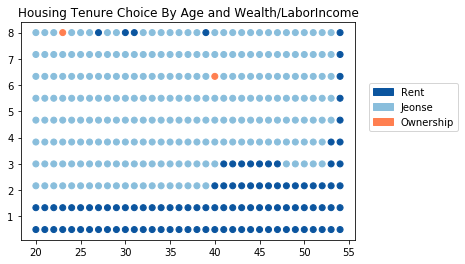

In [110]:
colormap = np.array(['#0b559f', '#89bedc','coral'])
plt.scatter(result1['age'], result1['X/Y'], c=colormap[d])

ht_a = mpatches.Patch(color='#0b559f', label='Rent') #0
ht_b = mpatches.Patch(color='#89bedc', label='Jeonse') #1
ht_c = mpatches.Patch(color='coral', label='Ownership') #2

plt.legend(handles=[ht_a,ht_b,ht_c], loc=(1.04,0.5))
plt.title('Housing Tenure Choice By Age and Wealth/LaborIncome')
plt.show() #should have better grid...

#Possible tradeoff 
#- house (no adjustment cost - good to have a long-run)
#- jeonse (cheaper to finance (tau_r > R_f) but as home bigger the transaction cost increases - only wealthy worth it?), 

In [94]:
#7.2. Saving and Portfolio Choice by Wealth and Housing Tenure (Rent and Jeonse and Housing Tenure)

for age in [0,10,20,30]:
    y=ygrid
    #y=np.concatenate((y,y))
    x=y**(-1)
    a1=a_r[age]
    alpha1=alpha_r[age]
    a2=a_j[age]
    alpha2=alpha_j[age]
    a3=a_p[age]
    alpha3=alpha_p[age]
    #a=np.concatenate((a1,a2))
    #alpha=np.concatenate((alpha1,alpha2))
    b=np.repeat(0,len(ygrid))
    c=np.repeat(1,len(ygrid))
    z=np.repeat(2,len(ygrid))
    #d=np.concatenate((b,c))
    y=pd.DataFrame(y)
    x=pd.DataFrame(x)
    a1=pd.DataFrame(a1)
    a2=pd.DataFrame(a2)
    a3=pd.DataFrame(a3)
    alpha1=pd.DataFrame(alpha1)
    alpha2=pd.DataFrame(alpha2)
    alpha3=pd.DataFrame(alpha3)
    b=pd.DataFrame(b)
    c=pd.DataFrame(c)
    z=pd.DataFrame(z)
    name1='result_r_'+str(age)
    name2='result_j_'+str(age)
    name3='result_p_'+str(age)
    vars()[name1] = pd.concat([y, x, a1, alpha1, b], axis=1, sort=False)
    vars()[name1].columns=['Y/X','X/Y','Saving Ratio','RiskyAssetRatio','HousingTenure']
    vars()[name2] = pd.concat([y, x, a2, alpha2, c], axis=1, sort=False)
    vars()[name2].columns=['Y/X','X/Y','Saving Ratio','RiskyAssetRatio','HousingTenure']
    vars()[name3] = pd.concat([y, x, a3, alpha3, z], axis=1, sort=False)
    vars()[name3].columns=['Y/X','X/Y','Saving Ratio','RiskyAssetRatio','HousingTenure']

In [95]:
#https://matplotlib.org/3.1.0/gallery/color/named_colors.html - color

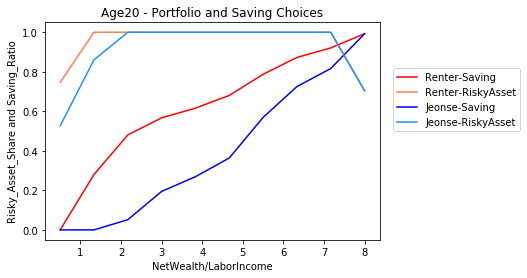

In [105]:
#1. Age-20-Choice

plt.plot(result_r_0['X/Y'], result_r_0['Saving Ratio'], color='red', label='Renter-Saving')
plt.plot(result_r_0['X/Y'], result_r_0['RiskyAssetRatio'], color='coral', label='Renter-RiskyAsset')
plt.plot(result_j_0['X/Y'], result_j_0['Saving Ratio'], color='blue', label='Jeonse-Saving')
plt.plot(result_j_0['X/Y'], result_j_0['RiskyAssetRatio'], color='dodgerblue', label='Jeonse-RiskyAsset')
#plt.plot(result_p_0['X/Y'], result_p_0['Saving Ratio'], color='forestgreen', label='Buyer-Saving')
#plt.plot(result_p_0['X/Y'], result_p_0['RiskyAssetRatio'], color='limegreen', label='Buyer-RiskyAsset')

plt.ylabel('Risky_Asset_Share and Saving_Ratio')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age20 - Portfolio and Saving Choices')
plt.legend(loc=(1.04,0.5))
plt.show()

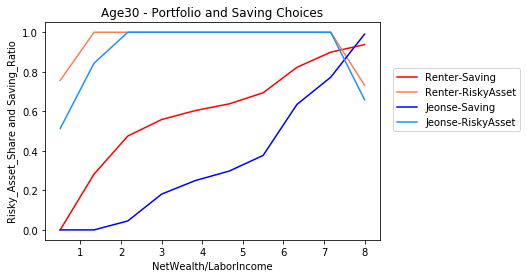

In [106]:
#2. Age-30-Choice

plt.plot(result_r_10['X/Y'], result_r_10['Saving Ratio'], color='red', label='Renter-Saving')
plt.plot(result_r_10['X/Y'], result_r_10['RiskyAssetRatio'], color='coral', label='Renter-RiskyAsset')
plt.plot(result_j_10['X/Y'], result_j_10['Saving Ratio'], color='blue', label='Jeonse-Saving')
plt.plot(result_j_10['X/Y'], result_j_10['RiskyAssetRatio'], color='dodgerblue', label='Jeonse-RiskyAsset')
#plt.plot(result_p_10['X/Y'], result_p_10['Saving Ratio'], color='forestgreen', label='Buyer-Saving')
#plt.plot(result_p_10['X/Y'], result_p_10['RiskyAssetRatio'], color='limegreen', label='Buyer-RiskyAsset')

plt.ylabel('Risky_Asset_Share and Saving_Ratio')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age30 - Portfolio and Saving Choices')
plt.legend(loc=(1.04,0.5))
plt.show()

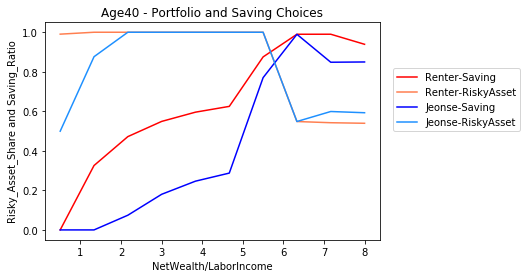

In [107]:
#3. Age-40-Choice

plt.plot(result_r_20['X/Y'], result_r_20['Saving Ratio'], color='red', label='Renter-Saving')
plt.plot(result_r_20['X/Y'], result_r_20['RiskyAssetRatio'], color='coral', label='Renter-RiskyAsset')
plt.plot(result_j_20['X/Y'], result_j_20['Saving Ratio'], color='blue', label='Jeonse-Saving')
plt.plot(result_j_20['X/Y'], result_j_20['RiskyAssetRatio'], color='dodgerblue', label='Jeonse-RiskyAsset')
#plt.plot(result_p_20['X/Y'], result_p_20['Saving Ratio'], color='forestgreen', label='Buyer-Saving')
#plt.plot(result_p_20['X/Y'], result_p_20['RiskyAssetRatio'], color='limegreen', label='Buyer-RiskyAsset')

plt.ylabel('Risky_Asset_Share and Saving_Ratio')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age40 - Portfolio and Saving Choices')
plt.legend(loc=(1.04,0.5))
plt.show()

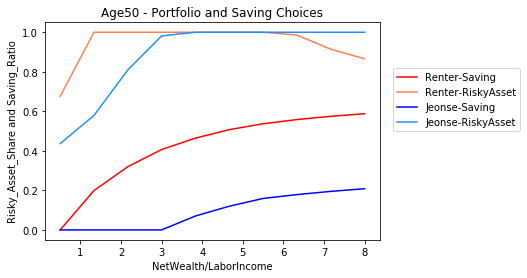

In [108]:
#4. Age-50-Choice

plt.plot(result_r_30['X/Y'], result_r_30['Saving Ratio'], color='red', label='Renter-Saving')
plt.plot(result_r_30['X/Y'], result_r_30['RiskyAssetRatio'], color='coral', label='Renter-RiskyAsset')
plt.plot(result_j_30['X/Y'], result_j_30['Saving Ratio'], color='blue', label='Jeonse-Saving')
plt.plot(result_j_30['X/Y'], result_j_30['RiskyAssetRatio'], color='dodgerblue', label='Jeonse-RiskyAsset')
#plt.plot(result_p_30['X/Y'], result_p_30['Saving Ratio'], color='forestgreen', label='Buyer-Saving')
#plt.plot(result_p_30['X/Y'], result_p_30['RiskyAssetRatio'], color='limegreen', label='Buyer-RiskyAsset')

plt.ylabel('Risky_Asset_Share and Saving_Ratio')
plt.xlabel('NetWealth/LaborIncome')
plt.title('Age50 - Portfolio and Saving Choices')
plt.legend(loc=(1.04,0.5))
plt.show()

In [ ]:
#8. More work

In [ ]:
#Understand the optimize function.. why so many error?
#Define state variable only one time for each whole cycle (whole y grid and h grid)
#Also, define the function once at age time.. 
#-> Change the structure of function!
#Non-linear minimization 이 아닌 방법이 ...